<a href="https://colab.research.google.com/github/SNMHZ/DART_ESG_Project/blob/main/Fscore_ESGscore(%EA%B3%B5%EA%B3%B5%EB%8D%B0%EC%9D%B4%ED%84%B0%EB%A1%9C_%EC%8A%A4%EC%BD%94%EC%96%B4%EB%A7%81_KCGS)_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 환경설정

## 라이브러리


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
!pip install PyMySQL

     |████████████████████████████████| 51kB 2.7MB/s 


In [ ]:
import pymysql

## 함수

In [ ]:
##################데이터 DB에서 가져오기 함수###################
#######input
#stock_list -> 종목 코드 리스트(string)
#start_date -> 쿼리 시작일(당일 포함)
#start_date -> 쿼리 종료일(당일 포함)
#cursor -> pymysql 데이터베이스 커서

#######output
#시계열 주가 정보.
#( col == 종목 코드 ) && ( row == 시계열[start_date:end_date] )

################################################################
def quarry_value(stock_list, start_date, end_date, cursor):
  #stock_list_result 생성. DB관계도 때문에 미리 세팅.
  sql = "SELECT * FROM table_info WHERE"
  for i, stock_code in enumerate(stock_list):
    if i:
      sql+=' or'
    sql+=" Symbol='"+stock_code+"'"
  cursor.execute(sql)
  stock_list_result = pd.DataFrame(cursor.fetchall())

  #관계도 바탕으로 각 주가 쿼리.
  r_df=pd.DataFrame(index=pd.date_range(start_date, end_date), dtype='int64')
  for i in range(len(stock_list_result)):
    print('\rfetching '+stock_list_result.loc[i][0]+' %d/%d'%(i+1, len(stock_list_result)), end='')
    #stock_list_result.loc[i][0] #기업코드 str
    #stock_list_result.loc[i][2] #테이블넘버 int
    #쿼리문 작성
    sql = "SELECT "+stock_list_result.loc[i][0]+" FROM rsp"+str(stock_list_result.loc[i][2])+" WHERE DATE BETWEEN '"+start_date+"' and '"+end_date+"';"
    cursor.execute(sql)
    result = cursor.fetchall()
    r_df[stock_list_result.loc[i][0]]=pd.DataFrame(result, index=pd.date_range(start_date, end_date), dtype='int64')[stock_list_result.loc[i][0]].astype('int64')
  print('\rfetching end.')
  return r_df

##############  기준정보 DB에서 가져오기 함수  #################
#######input
#start_date -> 쿼리 시작일(당일 포함)
#start_date -> 쿼리 종료일(당일 포함)
#cursor -> pymysql 데이터베이스 커서

#######output
#시계열 지수 정보
#( col == kospi, kospi200, kosdaq ) && ( row == 시계열[start_date:end_date] )

################################################################
def quarry_standard(start_date, end_date, cursor):
  #쿼리문 작성
  sql = "SELECT kospi, kospi200, kosdaq FROM standard_table WHERE DATE BETWEEN '"+start_date+"' and '"+end_date+"';"
  cursor.execute(sql)
  result = cursor.fetchall()
  r_df=pd.DataFrame(result, index=pd.date_range(start_date, end_date))
  for col in r_df.columns:
    r_df[col]=r_df[col].astype('float64')
  print('\rfetching end.')
  return r_df

#input  -> 위에서 쿼리한 시계열 주가 정보
#output -> 백테스트 변화율.
def backtest(value_df, seed_money=100000000):
  #지갑가치 조회
  def get_stock_wallet_price(stock_wallet, date):
    stock_wallet_value=0
    for stock_name in stock_wallet.keys():
      stock_wallet_value+=stock_wallet[stock_name]*value_df[stock_name][date]
    return stock_wallet_value

  current_money=seed_money
  screened_stock_count=len(value_df.columns)
  money_per_stock=current_money/screened_stock_count
  rebalance_date=value_df.index[0]

  #사놓을 거 지갑 만들기. (key-value)==(종목코드-구매 개수)
  stock_wallet={}
  for to_buy in value_df.columns:
    stock_wallet[to_buy] = int(money_per_stock//value_df[to_buy][rebalance_date])

  #백테스트 데이터프레임 뼈대 생성
  backtest=pd.DataFrame(index=value_df.index)

  stock_val_list=np.array([], dtype='int64')
  for date in value_df.index:
    stock_val_list = np.append(stock_val_list, get_stock_wallet_price(stock_wallet, date))
  backtest['stock_val']=stock_val_list
  cash=seed_money-get_stock_wallet_price(stock_wallet, rebalance_date)
  backtest['cash']=np.array([cash]*len(value_df), dtype='int64')
  backtest['total']=backtest['stock_val']+backtest['cash']
  backtest['total_change']=backtest['total']/backtest['total'][backtest.index[0]]-1

  return backtest

def visualize(standard_df, std_str, backtest_df_list=[], label_list=[]):
  plt.figure(figsize = (15,8))
  standard_df['total_change'].plot(linestyle='--', label=std_str)
  for i, m_df in enumerate(backtest_df_list):
    label_str=''
    if len(label_list)<=i:
      label_str=str(i)
    else:
      label_str=label_list[i]
    m_df['total_change'].plot(label=label_str)
  plt.plot()
  plt.legend(loc='upper left')
  plt.show()

## DB 커넥터(비공개 처리)


In [ ]:
#제가 개인적으로 설정해두고 이용하는 데이터베이스 서버입니다.
#아이디 비밀번호 등 정보가 유포되면 저에게 큰 문제가 생기니 유출하지 말아주세요..
db = pymysql.connect(
    user='', 
    passwd='', 
    host='', 
    db='', 
    charset='utf8'
)
m_cursor = db.cursor(pymysql.cursors.DictCursor)

## 데이터 로드

In [ ]:
#2011년도부터 2020년도까지 KCGS ESG DATA 로딩
ESG_DF_DICT={}
for i in range(10):
  ESG_DF_DICT['KCGS_ESG_%d'%(i+2011)]=pd.read_excel('https://github.com/SNMHZ/DART_ESG_Project/raw/main/KCGS_DATA/KCGS_ESG_%d.xlsx'%(i+2011), index_col=0)

In [ ]:
#텍스트로 구성된 등급을 숫자로 어떻게 변환 할 것 인가? 에 대한 정보(제 마음대로 정했습니다).
grade_num = {}
grade_num['S']=1
grade_num['A+']=1
grade_num['A']=2
grade_num['B+']=3
grade_num['B+이하']=3
grade_num['B']=4
grade_num['B이하']=5
grade_num['C']=6
grade_num['D']=7

In [ ]:
#텍스트로 구성된 등급을 숫자로 어떻게 변환 할 것 인가? 에 대한 정보(제 마음대로 정했습니다).
grade_num = {}
grade_num['S']=7
grade_num['A+']=7
grade_num['A']=6
grade_num['B+']=5
grade_num['B+이하']=5
grade_num['B']=4
grade_num['B이하']=3
grade_num['C']=2
grade_num['D']=1

In [ ]:
#######################   데이터 전처리   #######################
#기업코드 보정. ex) 5930 -> 'A005930',  298000 -> 'A298000'
#ESG등급 보정.  ex) 'A+' -> 1, A -> 2
#(보정 전 데이터) + (불필요 데이터. ex. 비고 등) 삭제
#################################################################
for i in range(10):
  ESG_DF_DICT['KCGS_ESG_%d'%(i+2011)]=ESG_DF_DICT['KCGS_ESG_%d'%(i+2011)].drop(columns=['비고 (조정시기)']).dropna()
  str_list=[]
  for num in ESG_DF_DICT['KCGS_ESG_%d'%(i+2011)]['기업코드']:
    str_list.append('A%06d'%num)
  ESG_DF_DICT['KCGS_ESG_%d'%(i+2011)]['기업코드_보정']=str_list
  for col in ['ESG등급', '환경', '사회', '지배구조']:
    m_list=[]
    for data in ESG_DF_DICT['KCGS_ESG_%d'%(i+2011)][col]:
      m_list.append(grade_num[data])
    ESG_DF_DICT['KCGS_ESG_%d'%(i+2011)][col+'N']=np.array(m_list, dtype='int64')
  for name in ['기업코드', 'ESG등급', '환경', '사회', '지배구조', '평가년도']:
    del ESG_DF_DICT['KCGS_ESG_%d'%(i+2011)][name]

In [ ]:
fscore = pd.read_excel("F_2020.xlsx", index_col=0)
fscore

,종목명,종목코드,시장구분,산업분류,IPO_D,F.Score
113,삼성엔지니어링,28050,코스피,서비스업,199612,9
156,일양약품,7570,코스피,의약품,197408,9
178,파라다이스,34230,코스닥,오락·문화,200211,9
247,삼양식품,3230,코스피,음식료품,197506,9
483,시노펙스,25320,코스닥,IT H/W,199504,9
...,...,...,...,...,...,...
1493,대성창투,27830,코스닥,금융,199911,1
1676,케이맥,43290,코스닥,기계·장비,201110,1
1704,피델릭스,32580,코스닥,IT H/W,199704,1
1836,아우딘퓨쳐스,227610,코스닥,화학,201707,1


In [ ]:
str_list=[]
for num in fscore['종목코드']:
  str_list.append('A%06d'%num)

In [ ]:
fscore['종목코드']=str_list

In [ ]:
y_2019_list=pd.read_excel("y2019_name_symbol.xlsx", index_col=0)
y_2019_list

,Symbol
name,
한국전력,A015760
한국항공우주,A047810
롯데케미칼,A011170
두산중공업,A034020
CJ대한통운,A000120
...,...
삼성전자,A005930
현대글로비스,A086280
현대위아,A011210


In [ ]:
comp_df =pd.read_excel('comp_df.xlsx', index_col=0)
comp_df

,E보정점수,S보정점수,G보정점수,합계
한온시스템,0.214286,0.333333,0.857143,1.404762
금호타이어,0.171429,0.333333,0.642857,1.147619
아모레퍼시픽,0.414286,0.333333,0.642857,1.390476
삼성전자,1.000000,0.333333,0.857143,2.190476
LG디스플레이,0.700000,0.333333,0.642857,1.676190
...,...,...,...,...
현대차,0.714286,0.333333,0.857143,1.904762
두산인프라코어,0.000000,0.333333,0.714286,1.047619
현대중공업지주,0.142857,0.333333,0.785714,1.261905
롯데칠성,0.142857,0.333333,0.642857,1.119048


In [ ]:
start_date='2020-01-01'
end_date='2020-10-08'

## F 스코어 데이터 전처리


In [ ]:
fscore.sort_values(by='F.Score', ascending=False)[:20]

,종목명,종목코드,시장구분,산업분류,IPO_D,F.Score
113,삼성엔지니어링,A028050,코스피,서비스업,199612,9
1092,삼륭물산,A014970,코스닥,종이·목재,199212,9
156,일양약품,A007570,코스피,의약품,197408,9
1868,제너셈,A217190,코스닥,IT H/W,201509,9
1590,한국큐빅,A021650,코스닥,화학,200301,9
1443,신화인터텍,A056700,코스닥,IT H/W,200112,9
1425,광명전기,A017040,코스피,전기전자,199009,9
1373,사조오양,A006090,코스피,음식료품,198612,9
1790,한네트,A052600,코스닥,통신방송서비스,200107,9
856,이지웰,A090850,코스닥,기타서비스,201312,9


In [ ]:
len(y_2019_list)

126

In [ ]:
fscore_my=fscore[fscore['종목코드'].isin(y_2019_list['Symbol'])]
fscore_my

,종목명,종목코드,시장구분,산업분류,IPO_D,F.Score
113,삼성엔지니어링,A028050,코스피,서비스업,199612,9
55,강원랜드,A035250,코스피,서비스업,200309,8
114,신세계,A004170,코스피,유통업,198508,8
217,코오롱인더,A120110,코스피,화학,201002,8
238,영풍,A000670,코스피,철강금속,197606,8
...,...,...,...,...,...,...
52,LG유플러스,A032640,코스피,통신업,200804,3
128,현대로템,A064350,코스피,운수장비,201310,3
145,OCI,A010060,코스피,화학,198507,3
174,아이에스동서,A010780,코스피,비금속광물,198601,3


In [ ]:
fscore_my=fscore_my.drop(columns=['시장구분', '산업분류', 'IPO_D'])
fscore_my

,종목명,종목코드,F.Score
113,삼성엔지니어링,A028050,9
55,강원랜드,A035250,8
114,신세계,A004170,8
217,코오롱인더,A120110,8
238,영풍,A000670,8
...,...,...,...
52,LG유플러스,A032640,3
128,현대로템,A064350,3
145,OCI,A010060,3
174,아이에스동서,A010780,3


In [ ]:
fscore_my.to_excel("F_2020_our_standard.xlsx")

# 테스트

## 비교군(kospi) 로드

In [ ]:
std_df=quarry_standard(start_date, end_date, m_cursor)
std_df['total_change']=std_df['kospi']/std_df['kospi'][std_df.index[0]]-1
std_df

fetching end.


,kospi,kospi200,kosdaq,total_change
2020-01-01,2197.67,293.77,669.83,0.000000
2020-01-02,2175.17,290.35,674.02,-0.010238
2020-01-03,2176.46,290.74,669.93,-0.009651
2020-01-04,2176.46,290.74,669.93,-0.009651
2020-01-05,2176.46,290.74,669.93,-0.009651
...,...,...,...,...
2020-10-04,2327.89,309.44,848.15,0.059254
2020-10-05,2358.00,313.51,858.39,0.072955
2020-10-06,2365.90,314.45,862.58,0.076549
2020-10-07,2386.94,317.35,869.66,0.086123


## (공공데이터로 스코어링) 가중치 1 : 0.7 : 0 만들기

In [ ]:
comp_10_7_0=comp_df.copy()
comp_10_7_0['E보정점수_10배']=comp_10_7_0['E보정점수']*10
comp_10_7_0['S보정점수_7배']=comp_10_7_0['S보정점수']*7
comp_10_7_0['G보정점수_0배']=comp_10_7_0['G보정점수']*0
comp_10_7_0['보정합']=comp_10_7_0['E보정점수_10배']+comp_10_7_0['S보정점수_7배']+comp_10_7_0['G보정점수_0배']
comp_10_7_0=comp_10_7_0.sort_values(by='보정합', ascending=False)
list_20_10_7_0=y_2019_list.transpose()[comp_10_7_0[:20].index].transpose()['Symbol'].to_list()

In [ ]:
comp_10_7_0

,E보정점수,S보정점수,G보정점수,합계,E보정점수_10배,S보정점수_7배,G보정점수_0배,보정합
삼성전자,1.000000,0.333333,0.857143,2.190476,10.000000,2.333333,0.0,12.333333
LG전자,0.757143,0.333333,0.714286,1.804762,7.571429,2.333333,0.0,9.904762
현대차,0.714286,0.333333,0.857143,1.904762,7.142857,2.333333,0.0,9.476190
SK하이닉스,0.714286,0.333333,0.857143,1.904762,7.142857,2.333333,0.0,9.476190
LG이노텍,0.714286,0.333333,0.642857,1.690476,7.142857,2.333333,0.0,9.476190
...,...,...,...,...,...,...,...,...
엔씨소프트,0.142857,0.000000,0.642857,0.785714,1.428571,0.000000,0.0,1.428571
GS리테일,0.142857,0.000000,0.500000,0.642857,1.428571,0.000000,0.0,1.428571
아시아나항공,0.142857,0.000000,0.357143,0.500000,1.428571,0.000000,0.0,1.428571
대림산업,0.085714,0.000000,0.500000,0.585714,0.857143,0.000000,0.0,0.857143


In [ ]:
comp_10_7_0['종목코드']=y_2019_list['Symbol']

In [ ]:
comp_10_7_0

,E보정점수,S보정점수,G보정점수,합계,E보정점수_10배,S보정점수_7배,G보정점수_0배,보정합,종목코드
삼성전자,1.000000,0.333333,0.857143,2.190476,10.000000,2.333333,0.0,12.333333,A005930
LG전자,0.757143,0.333333,0.714286,1.804762,7.571429,2.333333,0.0,9.904762,A066570
현대차,0.714286,0.333333,0.857143,1.904762,7.142857,2.333333,0.0,9.476190,A005380
SK하이닉스,0.714286,0.333333,0.857143,1.904762,7.142857,2.333333,0.0,9.476190,A000660
LG이노텍,0.714286,0.333333,0.642857,1.690476,7.142857,2.333333,0.0,9.476190,A011070
...,...,...,...,...,...,...,...,...,...
엔씨소프트,0.142857,0.000000,0.642857,0.785714,1.428571,0.000000,0.0,1.428571,A036570
GS리테일,0.142857,0.000000,0.500000,0.642857,1.428571,0.000000,0.0,1.428571,A007070
아시아나항공,0.142857,0.000000,0.357143,0.500000,1.428571,0.000000,0.0,1.428571,A020560
대림산업,0.085714,0.000000,0.500000,0.585714,0.857143,0.000000,0.0,0.857143,A000210


In [ ]:
comp_10_7_0=comp_10_7_0[comp_10_7_0['종목코드'].isin(fscore_my['종목코드'])]
comp_10_7_0

,E보정점수,S보정점수,G보정점수,합계,E보정점수_10배,S보정점수_7배,G보정점수_0배,보정합,종목코드
삼성전자,1.000000,0.333333,0.857143,2.190476,10.000000,2.333333,0.0,12.333333,A005930
LG전자,0.757143,0.333333,0.714286,1.804762,7.571429,2.333333,0.0,9.904762,A066570
현대차,0.714286,0.333333,0.857143,1.904762,7.142857,2.333333,0.0,9.476190,A005380
SK하이닉스,0.714286,0.333333,0.857143,1.904762,7.142857,2.333333,0.0,9.476190,A000660
LG이노텍,0.714286,0.333333,0.642857,1.690476,7.142857,2.333333,0.0,9.476190,A011070
...,...,...,...,...,...,...,...,...,...
엔씨소프트,0.142857,0.000000,0.642857,0.785714,1.428571,0.000000,0.0,1.428571,A036570
GS리테일,0.142857,0.000000,0.500000,0.642857,1.428571,0.000000,0.0,1.428571,A007070
아시아나항공,0.142857,0.000000,0.357143,0.500000,1.428571,0.000000,0.0,1.428571,A020560
대림산업,0.085714,0.000000,0.500000,0.585714,0.857143,0.000000,0.0,0.857143,A000210


In [ ]:
comp_10_7_0.to_excel('10_7_0보정.xlsx')

In [ ]:
list_20_10_7_0_val=quarry_value(list_20_10_7_0, start_date, end_date, m_cursor)

fetching end.


In [ ]:
bt_20_10_7_0 = backtest(list_20_10_7_0_val, seed_money=1000000000)

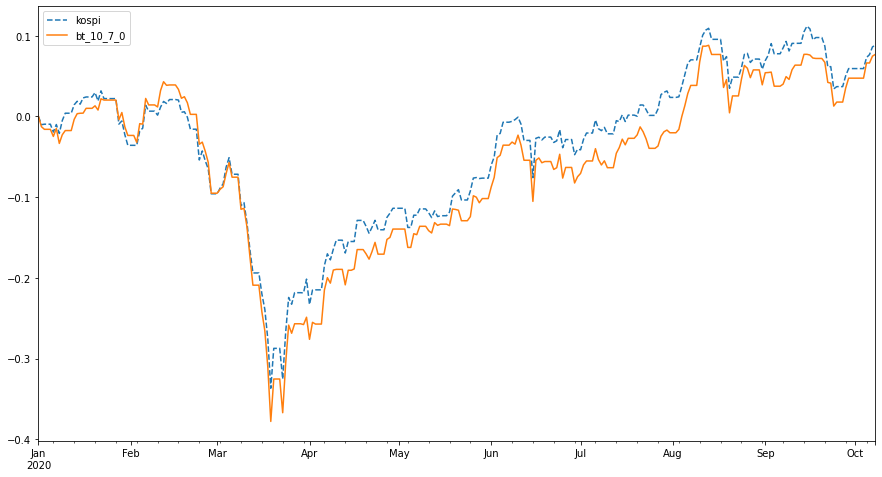

In [ ]:
visualize(std_df, 'kospi', [bt_20_10_7_0], ['bt_10_7_0'])

## F스코어 + ESG 스코어 (공공데이터로 스코어링)



#### 종목코드 추가 테스트

In [ ]:
y_2019_list_my=y_2019_list.copy()

In [ ]:
comp_add_code=comp_df.copy()

In [ ]:
comp_add_code['종목코드']=y_2019_list_my['Symbol']

In [ ]:
comp_add_code

,E보정점수,S보정점수,G보정점수,합계,종목코드
한온시스템,0.214286,0.333333,0.857143,1.404762,A018880
금호타이어,0.171429,0.333333,0.642857,1.147619,A073240
아모레퍼시픽,0.414286,0.333333,0.642857,1.390476,A090430
삼성전자,1.000000,0.333333,0.857143,2.190476,A005930
LG디스플레이,0.700000,0.333333,0.642857,1.676190,A034220
...,...,...,...,...,...
현대차,0.714286,0.333333,0.857143,1.904762,A005380
두산인프라코어,0.000000,0.333333,0.714286,1.047619,A042670
현대중공업지주,0.142857,0.333333,0.785714,1.261905,A267250
롯데칠성,0.142857,0.333333,0.642857,1.119048,A005300


#### F스코어 평준화 테스트

In [ ]:
fscore_my

,종목명,종목코드,F.Score
113,삼성엔지니어링,A028050,9
55,강원랜드,A035250,8
114,신세계,A004170,8
217,코오롱인더,A120110,8
238,영풍,A000670,8
...,...,...,...
52,LG유플러스,A032640,3
128,현대로템,A064350,3
145,OCI,A010060,3
174,아이에스동서,A010780,3


In [ ]:
#평준화
fscore_my['FScore']=fscore_my['F.Score']/max(fscore_my['F.Score'])
fscore_my

,종목명,종목코드,F.Score,FScore
113,삼성엔지니어링,A028050,9,1.000000
55,강원랜드,A035250,8,0.888889
114,신세계,A004170,8,0.888889
217,코오롱인더,A120110,8,0.888889
238,영풍,A000670,8,0.888889
...,...,...,...,...
52,LG유플러스,A032640,3,0.333333
128,현대로템,A064350,3,0.333333
145,OCI,A010060,3,0.333333
174,아이에스동서,A010780,3,0.333333


#### ESG합 평준화 테스트

In [ ]:
comp_10_7_0

,E보정점수,S보정점수,G보정점수,합계,E보정점수_10배,S보정점수_7배,G보정점수_0배,보정합,종목코드
삼성전자,1.000000,0.333333,0.857143,2.190476,10.000000,2.333333,0.0,12.333333,A005930
LG전자,0.757143,0.333333,0.714286,1.804762,7.571429,2.333333,0.0,9.904762,A066570
현대차,0.714286,0.333333,0.857143,1.904762,7.142857,2.333333,0.0,9.476190,A005380
SK하이닉스,0.714286,0.333333,0.857143,1.904762,7.142857,2.333333,0.0,9.476190,A000660
LG이노텍,0.714286,0.333333,0.642857,1.690476,7.142857,2.333333,0.0,9.476190,A011070
...,...,...,...,...,...,...,...,...,...
엔씨소프트,0.142857,0.000000,0.642857,0.785714,1.428571,0.000000,0.0,1.428571,A036570
GS리테일,0.142857,0.000000,0.500000,0.642857,1.428571,0.000000,0.0,1.428571,A007070
아시아나항공,0.142857,0.000000,0.357143,0.500000,1.428571,0.000000,0.0,1.428571,A020560
대림산업,0.085714,0.000000,0.500000,0.585714,0.857143,0.000000,0.0,0.857143,A000210


In [ ]:
comp_10_7_0['보정합평준화']=comp_10_7_0['보정합']/max(comp_10_7_0['보정합'])
comp_10_7_0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,E보정점수,S보정점수,G보정점수,합계,E보정점수_10배,S보정점수_7배,G보정점수_0배,보정합,종목코드,보정합평준화
삼성전자,1.000000,0.333333,0.857143,2.190476,10.000000,2.333333,0.0,12.333333,A005930,1.000000
LG전자,0.757143,0.333333,0.714286,1.804762,7.571429,2.333333,0.0,9.904762,A066570,0.803089
현대차,0.714286,0.333333,0.857143,1.904762,7.142857,2.333333,0.0,9.476190,A005380,0.768340
SK하이닉스,0.714286,0.333333,0.857143,1.904762,7.142857,2.333333,0.0,9.476190,A000660,0.768340
LG이노텍,0.714286,0.333333,0.642857,1.690476,7.142857,2.333333,0.0,9.476190,A011070,0.768340
...,...,...,...,...,...,...,...,...,...,...
엔씨소프트,0.142857,0.000000,0.642857,0.785714,1.428571,0.000000,0.0,1.428571,A036570,0.115830
GS리테일,0.142857,0.000000,0.500000,0.642857,1.428571,0.000000,0.0,1.428571,A007070,0.115830
아시아나항공,0.142857,0.000000,0.357143,0.500000,1.428571,0.000000,0.0,1.428571,A020560,0.115830
대림산업,0.085714,0.000000,0.500000,0.585714,0.857143,0.000000,0.0,0.857143,A000210,0.069498


#### 최종 함수

In [ ]:
## input 두 데이터프레임의 종목 목록은 같아야 함. 돌리기 전에 만들고 하기
def bt_0to1(fscore, esgscore, start_date, end_date, m_cursor):
  ##데이터 평준화
  fscore=fscore.copy()
  esgscore=esgscore.copy()
  fscore['합평준화']=fscore['F.Score']/max(fscore['F.Score'])
  esgscore['합평준화']=esgscore['보정합']/max(esgscore['보정합'])

  tested_df_list=[]
  tested_df_list1=[]
  tested_df_list2=[]
  ##수익률 테스트(fscore, esgscore) (1.0, 0,0), (0.9, 0.1), (0.8, 0.2), ... (0.0, 1.0)
  for i in np.arange(0, 1.1, 0.1):
    m_fscore=fscore.copy()
    m_esgscore=esgscore.copy()
    #가중치 곱
    m_fscore['가중곱']=m_fscore['합평준화']*(1-i)
    m_esgscore['가중곱']=m_esgscore['합평준화']*i

    #가중치 곱 두 데이터프레임 합
    m_fscore.index=m_fscore['종목코드']
    m_esgscore.index=m_esgscore['종목코드']
    
    sum_df = pd.DataFrame(index=m_fscore.index)
    sum_df['합']=m_fscore['가중곱']+m_esgscore['가중곱']

    #두 데이터 프레임 합 내림차순 정렬 & 상위 20개 추출
    sum_df=sum_df.sort_values(by='합', ascending=False)[:30]

    #DB에서 쿼리
    quarred=quarry_value(sum_df.index, start_date, end_date, m_cursor)
    
    #백테스트
    bt = backtest(quarred, seed_money=1000000000)
    
    #append
    tested_df_list.append(bt)
  
  ##테스트 리턴
  return tested_df_list

In [ ]:
## input 두 데이터프레임의 종목 목록은 같아야 함. 돌리기 전에 만들고 하기
def bt_0to1(fscore, esgscore, start_date, end_date, m_cursor):
  ##데이터 평준화
  fscore=fscore.copy()
  esgscore=esgscore.copy()
  fscore['합평준화']=fscore['F.Score']/max(fscore['F.Score'])
  esgscore['합평준화']=esgscore['보정합']/max(esgscore['보정합'])

  tested_df_list1=[]
  tested_df_list2=[]
  tested_df_list3=[]
  group_list = []
  ##수익률 테스트(fscore, esgscore) (1.0, 0,0), (0.9, 0.1), (0.8, 0.2), ... (0.0, 1.0)
  for i in np.arange(0, 1.1, 0.1):
    m_fscore=fscore.copy()
    m_esgscore=esgscore.copy()
    #가중치 곱
    m_fscore['가중곱']=m_fscore['합평준화']*(1-i)
    m_esgscore['가중곱']=m_esgscore['합평준화']*i

    #가중치 곱 두 데이터프레임 합
    m_fscore.index=m_fscore['종목코드']
    m_esgscore.index=m_esgscore['종목코드']
    
    sum_df = pd.DataFrame(index=m_fscore.index)
    sum_df['합']=m_fscore['가중곱']+m_esgscore['가중곱']

    #두 데이터 프레임 합 내림차순 정렬 & 상위 20개 추출
    #sum_df=sum_df.sort_values(by='합', ascending=False)
    sum_df1=sum_df.copy().sort_values(by='합', ascending=False)[:41]
    sum_df2=sum_df.copy().sort_values(by='합', ascending=False)[41:82]
    sum_df3=sum_df.copy().sort_values(by='합', ascending=False)[82:125]

    #DB에서 쿼리
    #quarred=quarry_value(sum_df.index, start_date, end_date, m_cursor)
    quarred1=quarry_value(sum_df1.index, start_date, end_date, m_cursor)
    quarred2=quarry_value(sum_df2.index, start_date, end_date, m_cursor)
    quarred3=quarry_value(sum_df3.index, start_date, end_date, m_cursor)
    group_list.append((sum_df1.index, sum_df2.index, sum_df3.index))


    #백테스트
    #bt = backtest(quarred, seed_money=1000000000)
    bt1 = backtest(quarred1, seed_money=1000000000)
    bt2 = backtest(quarred2, seed_money=1000000000)
    bt3 = backtest(quarred3, seed_money=1000000000)
    
    #append
    #tested_df_list.append(bt)
    tested_df_list1.append(bt1)
    tested_df_list2.append(bt2)
    tested_df_list3.append(bt3)
  
  ##테스트 리턴
  #return tested_df_list
  return tested_df_list1, tested_df_list2, tested_df_list3, group_list

In [ ]:
np.arange(0, 1.1, 0.1)

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [ ]:
for i in np.arange(0, 1.1, 0.1):
  print('%1.2f'%(1-i), '%1.2f'%(i))

1.00 0.00
0.90 0.10
0.80 0.20
0.70 0.30
0.60 0.40
0.50 0.50
0.40 0.60
0.30 0.70
0.20 0.80
0.10 0.90
0.00 1.00


### f스코어+우리기준

In [ ]:
t_fscore=pd.read_excel("F_2020_our_standard.xlsx", index_col=0)
t_comp=pd.read_excel('10_7_0보정.xlsx', index_col=0)
t_list=bt_0to1(t_fscore, t_comp, start_date, end_date, m_cursor)

fetching end.
fetching end.
fetching end.
fetching end.
fetching end.
fetching end.
fetching end.
fetching end.
fetching end.
fetching end.
fetching end.


In [ ]:
t_list[3]

,stock_val,cash,total,total_change
2020-01-01,999193346,806654,1000000000,0.000000
2020-01-02,984747102,806654,985553756,-0.014446
2020-01-03,982199524,806654,983006178,-0.016994
2020-01-04,982199524,806654,983006178,-0.016994
2020-01-05,982199524,806654,983006178,-0.016994
...,...,...,...,...
2020-10-04,892068850,806654,892875504,-0.107124
2020-10-05,916315110,806654,917121764,-0.082878
2020-10-06,914037880,806654,914844534,-0.085155
2020-10-07,920153620,806654,920960274,-0.079040


In [ ]:
for i in range(11):
  print(t_list[i]['total_change'][end_date])

-0.099087076
-0.08489461600000003
-0.08489461600000003
-0.08489461600000003
-0.057142616000000035
-0.002143416000000009
0.030661083999999894
0.0831211999999999
0.0831211999999999
0.08088965000000004
0.07693810000000001


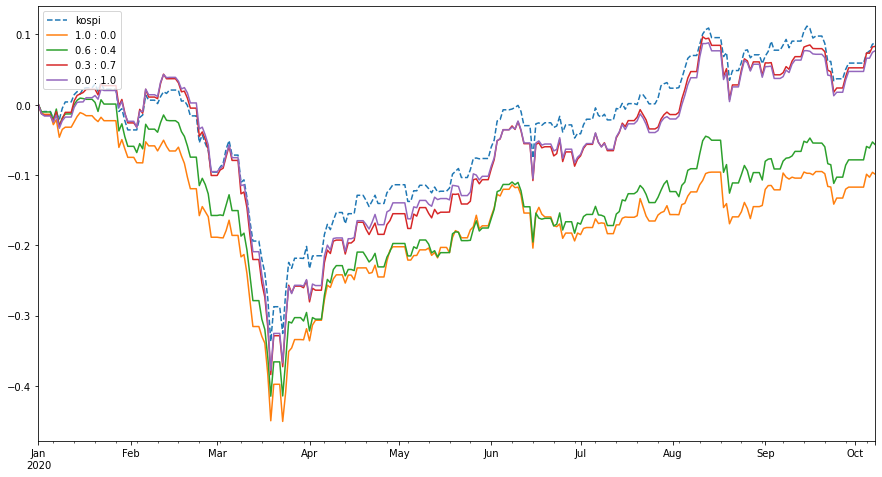

In [ ]:
##F-score : ESG-score
visualize(std_df, 'kospi', [t_list[0], t_list[4], t_list[7], t_list[10]], ['1.0 : 0.0', '0.6 : 0.4', '0.3 : 0.7', '0.0 : 1.0'])

## F스코어 + ESG 스코어 ( KCGS )

### f스코어 + KCGS

In [ ]:
kcgs19 = ESG_DF_DICT['KCGS_ESG_2019'].copy()
kcgs19

,기업명,기업코드_보정,ESG등급N,환경N,사회N,지배구조N
NO,,,,,,
923,AJ네트웍스,A095570,4,1,4,4
922,AJ렌터카,A068400,2,4,4,2
921,AK홀딩스,A006840,4,2,4,4
920,AP시스템,A265520,2,1,2,4
919,BGF,A027410,4,2,6,4
...,...,...,...,...,...,...
6,휴온스글로벌,A084110,4,2,5,5
5,휴젤,A145020,2,1,2,4
4,휴켐스,A069260,4,4,5,4


In [ ]:
kcgs19['종목코드']=kcgs19['기업코드_보정']
kcgs19['보정합']=kcgs19['ESG등급N']
kcgs19

,기업명,기업코드_보정,ESG등급N,환경N,사회N,지배구조N,종목코드,보정합
NO,,,,,,,,
923,AJ네트웍스,A095570,4,1,4,4,A095570,4
922,AJ렌터카,A068400,2,4,4,2,A068400,2
921,AK홀딩스,A006840,4,2,4,4,A006840,4
920,AP시스템,A265520,2,1,2,4,A265520,2
919,BGF,A027410,4,2,6,4,A027410,4
...,...,...,...,...,...,...,...,...
6,휴온스글로벌,A084110,4,2,5,5,A084110,4
5,휴젤,A145020,2,1,2,4,A145020,2
4,휴켐스,A069260,4,4,5,4,A069260,4


In [ ]:
t_comp

,E보정점수,S보정점수,G보정점수,합계,E보정점수_10배,S보정점수_7배,G보정점수_0배,보정합,종목코드
삼성전자,1.000000,0.333333,0.857143,2.190476,10.000000,2.333333,0,12.333333,A005930
LG전자,0.757143,0.333333,0.714286,1.804762,7.571429,2.333333,0,9.904762,A066570
현대차,0.714286,0.333333,0.857143,1.904762,7.142857,2.333333,0,9.476190,A005380
SK하이닉스,0.714286,0.333333,0.857143,1.904762,7.142857,2.333333,0,9.476190,A000660
LG이노텍,0.714286,0.333333,0.642857,1.690476,7.142857,2.333333,0,9.476190,A011070
...,...,...,...,...,...,...,...,...,...
엔씨소프트,0.142857,0.000000,0.642857,0.785714,1.428571,0.000000,0,1.428571,A036570
GS리테일,0.142857,0.000000,0.500000,0.642857,1.428571,0.000000,0,1.428571,A007070
아시아나항공,0.142857,0.000000,0.357143,0.500000,1.428571,0.000000,0,1.428571,A020560
대림산업,0.085714,0.000000,0.500000,0.585714,0.857143,0.000000,0,0.857143,A000210


In [ ]:
t_list=bt_0to1(t_fscore, kcgs19, start_date, end_date, m_cursor)

fetching end.
fetching end.
fetching end.
fetching end.
fetching end.
fetching end.
fetching end.
fetching end.
fetching end.
fetching end.
fetching end.


In [ ]:
for i in range(11):
  print(t_list[i]['total_change'][end_date])

-0.08579241000000004
-0.05605766000000001
-0.05493775999999995
-0.023392689999999994
-0.023444589999999987
-0.10255619000000005
-0.10255619000000005
-0.12431669000000001
0.0030748599999999016
0.0030748599999999016
-0.08417763


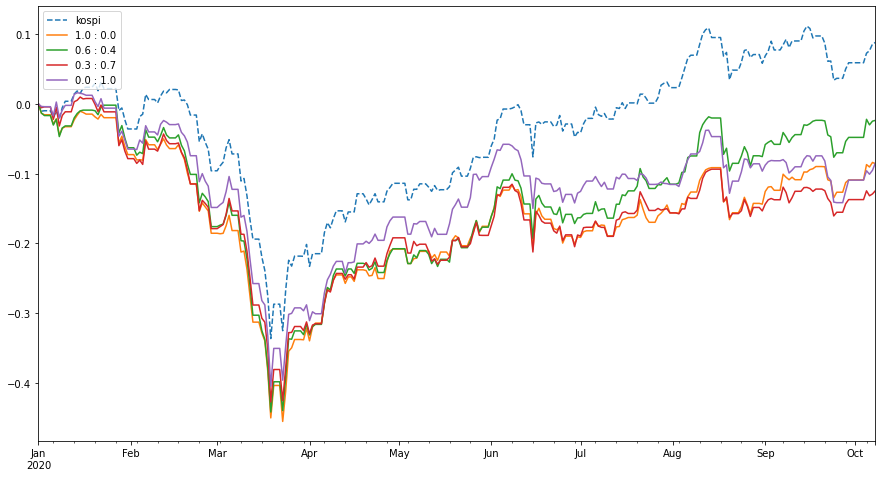

In [ ]:
##F-score : ESG-score(KCGS)
visualize(std_df, 'kospi', [t_list[0], t_list[4], t_list[7], t_list[10]], ['1.0 : 0.0', '0.6 : 0.4', '0.3 : 0.7', '0.0 : 1.0'])

### f스코어 + KCGS 상위 중위 하위 각 1/3 (하위로 갈 수 록 수익률이 좋음..)

In [ ]:
t1, t2, t3, group = bt_0to1(t_fscore, kcgs19, start_date, end_date, m_cursor)

fetching end.
fetching end.
fetching end.
fetching end.
fetching end.
fetching end.
fetching end.
fetching end.
fetching end.
fetching end.
fetching end.
fetching end.
fetching end.
fetching end.
fetching end.
fetching end.
fetching end.
fetching end.
fetching end.
fetching end.
fetching end.
fetching end.
fetching end.
fetching end.
fetching end.
fetching end.
fetching end.
fetching end.
fetching end.
fetching end.
fetching end.
fetching end.
fetching end.


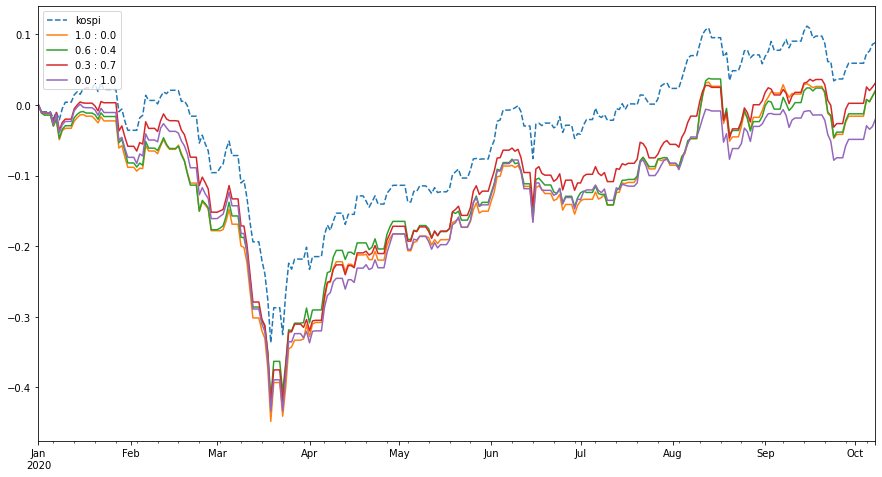

In [ ]:
##F-score : ESG-score(KCGS) 상위 1/3
visualize(std_df, 'kospi', [t1[0], t1[4], t1[7], t1[10]], ['1.0 : 0.0', '0.6 : 0.4', '0.3 : 0.7', '0.0 : 1.0'])

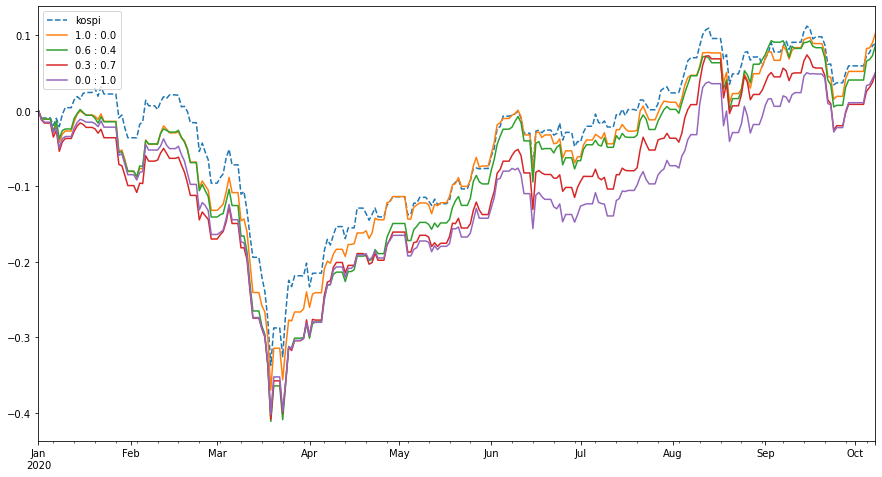

In [ ]:
##F-score : ESG-score(KCGS) 중위 1/3
visualize(std_df, 'kospi', [t2[0], t2[4], t2[7], t2[10]], ['1.0 : 0.0', '0.6 : 0.4', '0.3 : 0.7', '0.0 : 1.0'])

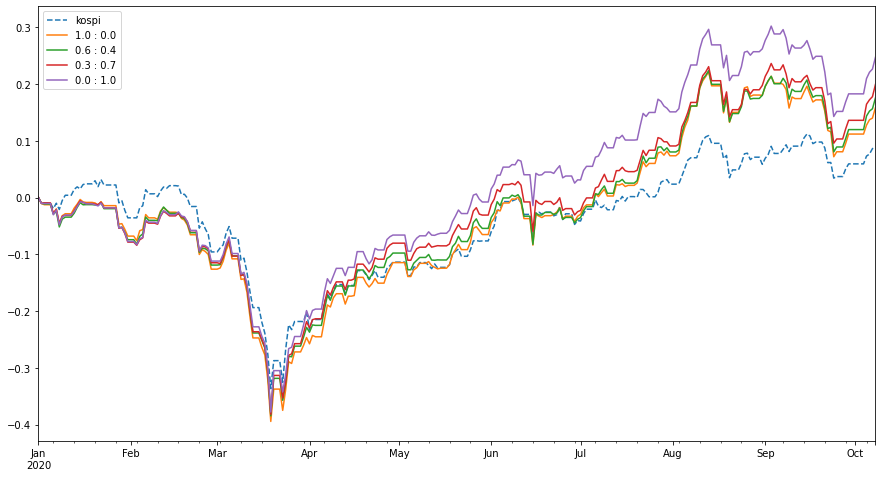

In [ ]:
##F-score : ESG-score(KCGS) 하위 1/3
visualize(std_df, 'kospi', [t3[0], t3[4], t3[7], t3[10]], ['1.0 : 0.0', '0.6 : 0.4', '0.3 : 0.7', '0.0 : 1.0'])

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49345 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50948 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51473 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54616 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 49345 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 50948 missing from current font.
  font.set_te

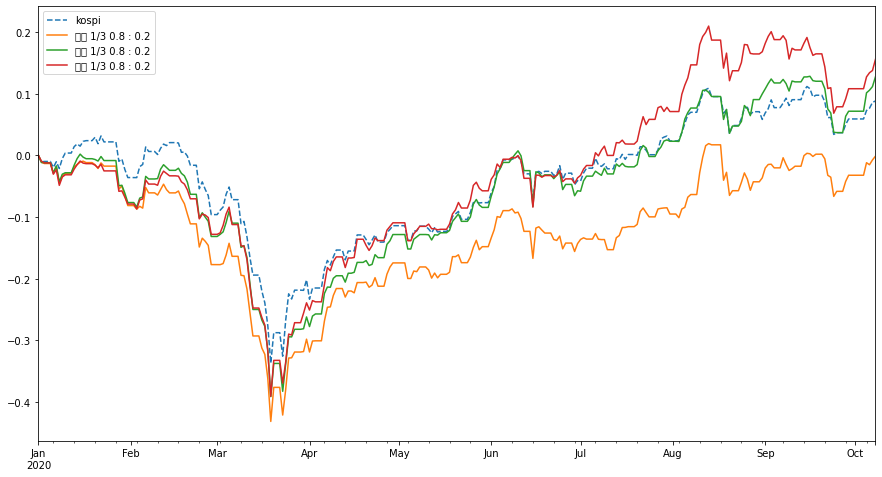

In [ ]:
visualize(std_df, 'kospi', [t1[2], t2[2], t3[2]], ['상위 1/3 0.8 : 0.2', '중위 1/3 0.8 : 0.2', '하위 1/3 0.8 : 0.2'])

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49345 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50948 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51473 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54616 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 49345 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 50948 missing from current font.
  font.set_te

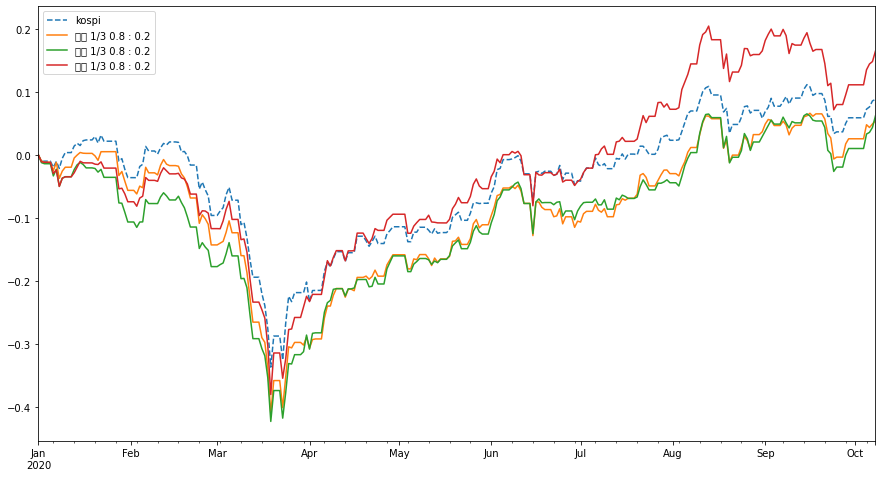

In [ ]:
visualize(std_df, 'kospi', [t1[5], t2[5], t3[5]], ['상위 1/3 0.8 : 0.2', '중위 1/3 0.8 : 0.2', '하위 1/3 0.8 : 0.2'])

In [ ]:
group[5][2]

Index(['A079550', 'A214320', 'A047040', 'A005250', 'A000240', 'A006260',
       'A005930', 'A003490', 'A004020', 'A034220', 'A011170', 'A000080',
       'A282330', 'A241560', 'A012630', 'A078930', 'A002380', 'A028670',
       'A004800', 'A081660', 'A032640', 'A015760', 'A018880', 'A064350',
       'A000670', 'A093050', 'A009410', 'A251270', 'A042660', 'A036570',
       'A003240', 'A035720', 'A020560', 'A051910', 'A001430', 'A000070',
       'A006650', 'A111770', 'A004370', 'A180640', 'A010780', 'A294870',
       'A285130'],
      dtype='object', name='종목코드')

In [ ]:
y_2019_list[group[5][2]]

KeyError: ignored

In [ ]:
fscore_my=fscore[fscore['종목코드'].isin(y_2019_list['Symbol'])]

In [ ]:
y_2019_list[y_2019_list['Symbol'].isin(group[5][2])]

,Symbol
name,
한국전력,A015760
롯데케미칼,A011170
태광산업,A003240
BGF리테일,A282330
한온시스템,A018880
한국테크놀로지그룹,A000240
GS,A078930
영풍,A000670
대한항공,A003490


### KCGS ESG 연간 주가에 반영되는 비율 알아보기 _ 피어슨 상관계수 활용 (결론 : 투자수익률과 상관없음)


#### 2011년

##### 전처리


In [ ]:
ESG_DF_DICT['KCGS_ESG_2011'].copy()

,기업명,기업코드_보정,ESG등급N,환경N,사회N,지배구조N
NO,,,,,,
663,AK홀딩스,A006840,3,3,3,4
662,BYC,A001460,3,3,3,4
659,CJ대한통운,A000120,5,3,5,4
657,CJ제일제당,A097950,5,6,5,5
653,DB손해보험,A005830,6,5,6,6
...,...,...,...,...,...,...
12,화천기계,A010660,3,3,3,4
8,효성,A004800,3,5,3,5
6,후성,A093370,3,3,3,2


In [ ]:
start_date
end_date

In [ ]:
data_2012=quarry_value(ESG_DF_DICT['KCGS_ESG_2011']['기업코드_보정'], '2012-01-01', '2012-12-31', m_cursor)

fetching end.


In [ ]:
data_2012

,A000020,A000040,A000060,A000070,A000100,A000120,A000150,A000180,A000210,A000230,A000240,A000270,A000300,A000370,A000390,A000430,A000490,A000640,A000660,A000700,A000720,A000760,A000810,A000880,A000910,A000990,A001060,A001120,A001140,A001210,A001230,A001250,A001260,A001390,A001430,A001450,A001460,A001560,A001680,A001740,...,A047050,A049770,A051600,A051900,A051910,A052690,A053690,A055550,A058430,A058730,A064960,A066570,A069260,A071950,A071970,A077970,A079430,A081000,A084010,A085310,A086280,A086790,A089470,A090080,A090350,A090430,A092200,A092220,A093230,A093240,A093370,A095720,A097230,A097950,A103140,A103590,A105560,A107590,A108670,A109070
2012-01-01,4080,4062,11800,77200,21441,75000,114955,1475,89800,8165,22407,66700,2873,6962,3500,4820,3675,65168,21950,4148,70400,7000,211000,32248,6220,7250,10819,47150,937,24839,18517,7360,3016383,7630,46000,34500,154000,5400,16100,10100,...,28950,71600,41200,487500,317500,92600,8050,39750,17450,1885,30800,74400,19950,814,2564709,47097,7820,8542,6440,3002,192000,35550,5330,1298,2970,105227,6151,4239,2440,2380,7795,12410,173445,289500,26200,6070,36300,12260,86900,42245
2012-01-02,4085,4221,11450,78400,21441,74200,115356,1460,90300,8198,22333,66500,2695,6934,3400,4745,3730,67516,23450,4110,71900,6790,205500,32150,6070,7740,10895,46000,929,24889,18291,7253,3016383,7670,43300,33150,154000,5380,15850,9790,...,28450,72600,40700,479500,320000,93000,8000,39600,17400,1890,29750,76100,19650,823,2555646,47792,7590,8407,6500,3022,190000,35100,5210,1253,2920,104927,5917,4308,2624,2310,7766,12254,179055,295000,26100,5950,36100,12309,87500,41903
2012-01-03,4130,4826,11850,82500,21357,80400,116562,1475,93500,8089,22531,68100,2641,6990,3405,4830,3760,68397,23650,4132,72500,6720,213000,32734,6080,7710,11009,47500,953,24591,18697,7253,3459969,7600,46000,33100,153500,5340,15600,9970,...,28900,73500,40550,499000,330500,93200,7970,41350,17700,1909,30350,77400,20100,833,2564709,48661,7560,8484,6470,3022,198500,36750,5330,1262,2945,108028,5961,4326,2496,2352,7961,12605,184665,308000,26800,6080,37300,12309,88000,43613
2012-01-04,4150,5547,11800,82900,21609,80800,115356,1578,94300,8035,21640,68700,2726,6981,3410,4815,3800,66782,23850,4072,72600,6870,212000,32637,5960,7980,10743,49400,958,24096,18652,7360,3563473,7640,47350,32650,153500,5370,15550,9980,...,28600,74700,40500,482500,324500,91200,7750,40550,17700,1871,30750,74700,20150,957,2591896,47966,7380,8870,6470,3086,203000,35900,5300,1257,2930,107028,5961,4349,2512,2301,7628,12801,187938,306000,28200,6430,36700,12698,88800,43613
2012-01-05,4270,5308,11600,83400,22029,83700,116562,1578,94100,8057,22135,68400,2659,6990,3425,4720,3755,67810,24000,4088,72000,7250,214000,32734,6040,8050,10971,50000,999,24096,19014,7609,3548686,7810,48150,32200,153500,5320,15750,10300,...,28350,76600,41200,483000,331500,89100,7750,40200,18000,1909,30900,73900,20650,997,2605490,48835,7090,8735,6720,3074,203000,34750,5390,1275,2915,106627,5909,4523,2508,2389,7648,12722,191211,307500,28000,6730,36800,12358,87700,43784
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-12-27,6040,2981,14150,72100,30017,102000,101618,1760,84500,12704,19550,57200,1470,5701,4270,8880,5470,78524,25750,3077,70000,6790,217000,33512,4300,6390,10975,48000,995,21121,12284,8426,499835,11100,29200,32500,184000,5300,27100,8560,...,39650,75300,60900,654000,329000,69000,6750,38600,15150,2723,23550,73400,25650,984,2315488,31352,5980,6216,7950,2610,220000,34600,4760,1748,4560,123032,3739,2940,1040,2120,4764,4948,116877,353000,33200,4540,37600,26564,77200,30450
2012-12-28,6040,3018,14150,71000,29092,100500,101618,1760,87000,12921,19800,56500,1490,5729,4350,8630,5660,79992,25750,3072,70000,6610,218000,33269,4360,6330,11253,48350,1016,21269,12375,8462,

In [ ]:
data_2012['A000020'][-1]

6040

In [ ]:
for name in data_2012.columns:
  m_df[name]['수익률']=(data_2012[name][-1]-data_2012[name][0])/data_2012[name][0]

In [ ]:
m_df=pd.DataFrame(columns=data_2012.columns, index=['수익률'])

In [ ]:
m_df.transpose()['수익률']

A000020     0.480392
A000040    -0.257016
A000060     0.199153
A000070   -0.0803109
A000100      0.35684
             ...    
A103590    -0.252883
A105560    0.0440771
A107590       1.1509
A108670   -0.0886076
A109070    -0.260054
Name: 수익률, Length: 275, dtype: object

In [ ]:
kcgs2011=ESG_DF_DICT['KCGS_ESG_2011'].copy()

In [ ]:
kcgs2011.index=kcgs2011['기업코드_보정']

In [ ]:
kcgs2011['수익률']=m_df.transpose()['수익률']

In [ ]:
kcgs2011

,기업명,기업코드_보정,ESG등급N,환경N,사회N,지배구조N,수익률
기업코드_보정,,,,,,,
A006840,AK홀딩스,A006840,3,3,3,4,-0.154339
A001460,BYC,A001460,3,3,3,4,0.194805
A000120,CJ대한통운,A000120,5,3,5,4,0.34
A097950,CJ제일제당,A097950,5,6,5,5,0.227979
A005830,DB손해보험,A005830,6,5,6,6,-0.139513
...,...,...,...,...,...,...,...
A010660,화천기계,A010660,3,3,3,4,-0.174138
A004800,효성,A004800,3,5,3,5,0.37314
A093370,후성,A093370,3,3,3,2,-0.388839


In [ ]:
kcgs2011=kcgs2011.drop(columns=['기업명', '기업코드_보정'])

In [ ]:
kcgs2011['수익률']=kcgs2011['수익률'].astype('float64')

In [ ]:
kcgs2011

,ESG등급N,환경N,사회N,지배구조N,수익률
기업코드_보정,,,,,
A006840,3,3,3,4,-0.154339
A001460,3,3,3,4,0.194805
A000120,5,3,5,4,0.340000
A097950,5,6,5,5,0.227979
A005830,6,5,6,6,-0.139513
...,...,...,...,...,...
A010660,3,3,3,4,-0.174138
A004800,3,5,3,5,0.373140
A093370,3,3,3,2,-0.388839


##### 결과

In [ ]:
kcgs2011.corr(method='pearson')

,ESG등급N,환경N,사회N,지배구조N,수익률
ESG등급N,1.000000,0.763974,0.991769,0.576778,-0.078628
환경N,0.763974,1.000000,0.762945,0.538931,-0.053181
사회N,0.991769,0.762945,1.000000,0.574395,-0.087446
지배구조N,0.576778,0.538931,0.574395,1.000000,-0.105992
수익률,-0.078628,-0.053181,-0.087446,-0.105992,1.000000


#### 2012년

In [ ]:
data_2013=quarry_value(ESG_DF_DICT['KCGS_ESG_2012']['기업코드_보정'], '2013-01-01', '2013-12-31', m_cursor)

fetching end.


In [ ]:
kcgs2012=ESG_DF_DICT['KCGS_ESG_2012'].copy()
m_df=pd.DataFrame(columns=data_2013.columns, index=['수익률'])
for name in data_2013.columns:
  m_df[name]['수익률']=(data_2013[name][-1]-data_2013[name][0])/data_2013[name][0]
kcgs2012.index=kcgs2012['기업코드_보정']
kcgs2012['수익률']=m_df.transpose()['수익률'].astype('float64')
kcgs2012['수익률']=kcgs2012['수익률']
kcgs2012=kcgs2012.drop(columns=['기업명', '기업코드_보정'])
kcgs2012.corr(method='pearson')

,ESG등급N,환경N,사회N,지배구조N,수익률
ESG등급N,1.000000,0.727954,0.829259,0.582558,-0.093986
환경N,0.727954,1.000000,0.583532,0.379354,-0.051109
사회N,0.829259,0.583532,1.000000,0.501813,-0.064436
지배구조N,0.582558,0.379354,0.501813,1.000000,-0.013055
수익률,-0.093986,-0.051109,-0.064436,-0.013055,1.000000


#### 2013 ~ 2016


##### 함수

In [ ]:
def pearson_esg(year):
  kcgs2012=ESG_DF_DICT['KCGS_ESG_%d'%(year)].copy()
  data_2013=quarry_value(kcgs2012['기업코드_보정'], '%d-01-01'%(year+1), '%d-12-31'%(year+1), m_cursor)
  m_df=pd.DataFrame(columns=data_2013.columns, index=['수익률'])
  for name in data_2013.columns:
    m_df[name]['수익률']=(data_2013[name][-1]-data_2013[name][0])/data_2013[name][0]
  kcgs2012.index=kcgs2012['기업코드_보정']
  kcgs2012['수익률']=m_df.transpose()['수익률'].astype('float64')
  kcgs2012['수익률']=kcgs2012['수익률']
  kcgs2012=kcgs2012.drop(columns=['기업명', '기업코드_보정'])
  return kcgs2012.corr(method='pearson')

In [ ]:
pearson_esg(2013)

fetching end.


,ESG등급N,환경N,사회N,지배구조N,수익률
ESG등급N,1.000000,0.742790,0.856595,0.579982,-0.185887
환경N,0.742790,1.000000,0.678534,0.360280,-0.178025
사회N,0.856595,0.678534,1.000000,0.475601,-0.139111
지배구조N,0.579982,0.360280,0.475601,1.000000,-0.177092
수익률,-0.185887,-0.178025,-0.139111,-0.177092,1.000000


In [ ]:
pearson_esg(2014)

fetching end.


,ESG등급N,환경N,사회N,지배구조N,수익률
ESG등급N,1.000000,0.732538,0.819446,0.600858,-0.132048
환경N,0.732538,1.000000,0.622730,0.376409,-0.144499
사회N,0.819446,0.622730,1.000000,0.472675,-0.138239
지배구조N,0.600858,0.376409,0.472675,1.000000,-0.153053
수익률,-0.132048,-0.144499,-0.138239,-0.153053,1.000000


In [ ]:
pearson_esg(2015)

fetching end.


,ESG등급N,환경N,사회N,지배구조N,수익률
ESG등급N,1.000000,0.595793,0.771613,0.509960,0.002531
환경N,0.595793,1.000000,0.549241,0.138488,0.041933
사회N,0.771613,0.549241,1.000000,0.327889,-0.018641
지배구조N,0.509960,0.138488,0.327889,1.000000,0.011164
수익률,0.002531,0.041933,-0.018641,0.011164,1.000000


In [ ]:
pearson_esg(2016)

fetching end.


,ESG등급N,환경N,사회N,지배구조N,수익률
ESG등급N,1.000000,0.610654,0.787459,0.524737,0.096335
환경N,0.610654,1.000000,0.521789,0.159462,0.080842
사회N,0.787459,0.521789,1.000000,0.314344,0.095243
지배구조N,0.524737,0.159462,0.314344,1.000000,0.095666
수익률,0.096335,0.080842,0.095243,0.095666,1.000000


#### 2017

In [ ]:
data_2018=quarry_value(ESG_DF_DICT['KCGS_ESG_2017']['기업코드_보정'], '2018-01-01', '2018-12-31', m_cursor)

fetching end.


In [ ]:
kcgs2017=ESG_DF_DICT['KCGS_ESG_2017'].copy()
m_df=pd.DataFrame(columns=data_2018.columns, index=['수익률'])
for name in data_2018.columns:
  m_df[name]['수익률']=(data_2018[name][-1]-data_2018[name][0])/data_2018[name][0]
kcgs2017.index=kcgs2017['기업코드_보정']
kcgs2017['수익률']=m_df.transpose()['수익률'].astype('float64')
kcgs2017['수익률']=kcgs2017['수익률']
kcgs2017=kcgs2017.drop(columns=['기업명', '기업코드_보정'])
kcgs2017.corr(method='pearson')

,ESG등급N,환경N,사회N,지배구조N,수익률
ESG등급N,1.000000,0.593777,0.737206,0.533918,-0.065532
환경N,0.593777,1.000000,0.536609,0.177471,-0.032402
사회N,0.737206,0.536609,1.000000,0.303703,-0.051875
지배구조N,0.533918,0.177471,0.303703,1.000000,-0.075068
수익률,-0.065532,-0.032402,-0.051875,-0.075068,1.000000


#### 2018

In [ ]:
data_2019=quarry_value(ESG_DF_DICT['KCGS_ESG_2018']['기업코드_보정'], '2019-01-01', '2019-12-31', m_cursor)

fetching end.


In [ ]:
kcgs2018=ESG_DF_DICT['KCGS_ESG_2018'].copy()
m_df=pd.DataFrame(columns=data_2019.columns, index=['수익률'])
for name in data_2019.columns:
  m_df[name]['수익률']=(data_2019[name][-1]-data_2019[name][0])/data_2019[name][0]
kcgs2018.index=kcgs2018['기업코드_보정']
kcgs2018['수익률']=m_df.transpose()['수익률'].astype('float64')
kcgs2018['수익률']=kcgs2018['수익률']
kcgs2018=kcgs2018.drop(columns=['기업명', '기업코드_보정'])
kcgs2018.corr(method='pearson')

,ESG등급N,환경N,사회N,지배구조N,수익률
ESG등급N,1.000000,0.643345,0.781991,0.588906,-0.052668
환경N,0.643345,1.000000,0.565969,0.315211,0.001428
사회N,0.781991,0.565969,1.000000,0.460580,-0.058031
지배구조N,0.588906,0.315211,0.460580,1.000000,-0.049889
수익률,-0.052668,0.001428,-0.058031,-0.049889,1.000000


##### 테스트

In [ ]:
ESG_DF_DICT['KCGS_ESG_2011'].copy()

In [ ]:
data_2012=quarry_value(ESG_DF_DICT['KCGS_ESG_2011']['기업코드_보정'], '2012-01-01', '2012-12-31', m_cursor)

In [ ]:
m_df=pd.DataFrame(columns=data_2012.columns, index=['수익률'])

In [ ]:
for name in data_2012.columns:
  m_df[name]['수익률']=(data_2012[name][-1]-data_2012[name][0])/data_2012[name][0]

In [ ]:
kcgs2011['수익률']=m_df.transpose()['수익률'].astype('float64')

In [ ]:
kcgs2011['수익률']=kcgs2011['수익률']

In [ ]:
kcgs2011=kcgs2011.drop(columns=['기업명', '기업코드_보정'])

#### 2019


In [ ]:
def pearson_esg_19(year):
  kcgs2012=ESG_DF_DICT['KCGS_ESG_%d'%(year)].copy()
  data_2013=quarry_value(kcgs2012['기업코드_보정'], '%d-01-01'%(year+1), '%d-10-08'%(year+1), m_cursor)
  m_df=pd.DataFrame(columns=data_2013.columns, index=['수익률'])
  for name in data_2013.columns:
    m_df[name]['수익률']=(data_2013[name][-1]-data_2013[name][0])/data_2013[name][0]
  kcgs2012.index=kcgs2012['기업코드_보정']
  kcgs2012['수익률']=m_df.transpose()['수익률'].astype('float64')
  kcgs2012['수익률']=kcgs2012['수익률']
  kcgs2012=kcgs2012.drop(columns=['기업명', '기업코드_보정'])
  return kcgs2012.corr(method='pearson')

In [ ]:
pearson_esg_19(2019)

fetching end.


,ESG등급N,환경N,사회N,지배구조N,수익률
ESG등급N,1.000000,0.579418,0.702321,0.793252,-0.042138
환경N,0.579418,1.000000,0.418540,0.263182,-0.055201
사회N,0.702321,0.418540,1.000000,0.444582,-0.039207
지배구조N,0.793252,0.263182,0.444582,1.000000,-0.023281
수익률,-0.042138,-0.055201,-0.039207,-0.023281,1.000000


### f스코어 7점 이상 && ESG 저등급 cut_off -> 백테결과


#### 2014

##### 전처리


In [ ]:
f2014=pd.read_excel("F_2014.xlsx", index_col=0)
f2014

,종목명,종목코드,시장구분,산업분류,IPO_D,F.Score
1,삼성전자,5930,코스피,전기전자,197506,7
2,SK하이닉스,660,코스피,전기전자,199612,8
3,NAVER,35420,코스피,서비스업,200811,6
4,LG화학,51910,코스피,화학,200104,6
5,현대차,5380,코스피,운수장비,197406,4
...,...,...,...,...,...,...
1466,엘디티,96870,코스닥,IT H/W,200805,4
1467,에이엔피,15260,코스피,전기전자,198801,4
1468,일정실업,8500,코스피,섬유의복,199408,5
1469,한국주강,25890,코스피,기계,199707,3


In [ ]:
str_list=[]
for num in f2014['종목코드']:
  str_list.append('A%06d'%num)

In [ ]:
f2014['종목코드']=str_list

In [ ]:
f2014

,종목명,종목코드,시장구분,산업분류,IPO_D,F.Score
1,삼성전자,A005930,코스피,전기전자,197506,7
2,SK하이닉스,A000660,코스피,전기전자,199612,8
3,NAVER,A035420,코스피,서비스업,200811,6
4,LG화학,A051910,코스피,화학,200104,6
5,현대차,A005380,코스피,운수장비,197406,4
...,...,...,...,...,...,...
1466,엘디티,A096870,코스닥,IT H/W,200805,4
1467,에이엔피,A015260,코스피,전기전자,198801,4
1468,일정실업,A008500,코스피,섬유의복,199408,5
1469,한국주강,A025890,코스피,기계,199707,3


In [ ]:
kcgs2013=ESG_DF_DICT['KCGS_ESG_2013'].copy()
kcgs2013

,기업명,기업코드_보정,ESG등급N,환경N,사회N,지배구조N
NO,,,,,,
690,AK홀딩스,A006840,3,3,3,2
689,BNK금융지주,A138930,5,3,6,6
688,BYC,A001460,3,3,3,4
687,CJ,A001040,5,3,6,4
686,CJ CGV,A079160,3,3,3,4
...,...,...,...,...,...,...
5,휴니드테크놀러지스,A005870,3,3,3,4
4,휴스틸,A005010,3,3,3,4
3,휴켐스,A069260,5,5,5,4


In [ ]:
#교집합
f2014=f2014[f2014['종목코드'].isin(ESG_DF_DICT['KCGS_ESG_2013']['기업코드_보정'])]
f2014

,종목명,종목코드,시장구분,산업분류,IPO_D,F.Score
1,삼성전자,A005930,코스피,전기전자,197506,7
2,SK하이닉스,A000660,코스피,전기전자,199612,8
3,NAVER,A035420,코스피,서비스업,200811,6
4,LG화학,A051910,코스피,화학,200104,6
5,현대차,A005380,코스피,운수장비,197406,4
...,...,...,...,...,...,...
1465,부산주공,A005030,코스피,운수장비,197512,4
1467,에이엔피,A015260,코스피,전기전자,198801,4
1468,일정실업,A008500,코스피,섬유의복,199408,5
1469,한국주강,A025890,코스피,기계,199707,3


In [ ]:
kcgs2013=kcgs2013[kcgs2013['기업코드_보정'].isin(f2014['종목코드'])]
kcgs2013

,기업명,기업코드_보정,ESG등급N,환경N,사회N,지배구조N
NO,,,,,,
690,AK홀딩스,A006840,3,3,3,2
689,BNK금융지주,A138930,5,3,6,6
688,BYC,A001460,3,3,3,4
687,CJ,A001040,5,3,6,4
686,CJ CGV,A079160,3,3,3,4
...,...,...,...,...,...,...
6,휠라코리아,A081660,3,3,3,4
5,휴니드테크놀러지스,A005870,3,3,3,4
4,휴스틸,A005010,3,3,3,4


##### 거르기

In [ ]:
f2014.sort_values(by='F.Score', ascending=False)

,종목명,종목코드,시장구분,산업분류,IPO_D,F.Score
1434,이스타코,A015020,코스피,서비스업,198812,9
800,부산산업,A011390,코스피,비금속광물,199009,9
391,웅진씽크빅,A095720,코스피,서비스업,200705,9
424,경방,A000050,코스피,유통업,195603,9
403,효성ITX,A094280,코스피,서비스업,200710,9
...,...,...,...,...,...,...
436,현대차증권,A001500,코스피,금융업,199006,1
918,대창,A012800,코스피,철강금속,198912,1
1367,동원수산,A030720,코스피,어업,199611,1
97,GS건설,A006360,코스피,건설업,198108,1


In [ ]:
f2014[f2014['F.Score']>=7]

,종목명,종목코드,시장구분,산업분류,IPO_D,F.Score
1,삼성전자,A005930,코스피,전기전자,197506,7
2,SK하이닉스,A000660,코스피,전기전자,199612,8
20,한국전력,A015760,코스피,전기가스업,198908,8
37,코웨이,A021240,코스피,서비스업,200108,8
38,LG디스플레이,A034220,코스피,전기전자,200407,8
...,...,...,...,...,...,...
1414,경인전자,A009140,코스피,전기전자,198906,7
1415,삼화전자,A011230,코스피,전기전자,198705,7
1434,이스타코,A015020,코스피,서비스업,198812,9
1439,태원물산,A001420,코스피,운수장비,197506,7


In [ ]:
v2014=quarry_value(f2014[f2014['F.Score']>=7]['종목코드'], '2014-01-01', '2014-12-31', m_cursor)

fetching end.


In [ ]:
bt2014=backtest(v2014, seed_money=1000000000)

In [ ]:
std_df=quarry_standard('2014-01-01', '2014-12-31', m_cursor)
std_df['total_change']=std_df['kospi']/std_df['kospi'][std_df.index[0]]-1
std_df

fetching end.


,kospi,kospi200,kosdaq,total_change
2014-01-01,2011.34,264.24,499.99,0.000000
2014-01-02,1967.19,257.64,496.28,-0.021951
2014-01-03,1946.14,254.48,499.33,-0.032416
2014-01-04,1946.14,254.48,499.33,-0.032416
2014-01-05,1946.14,254.48,499.33,-0.032416
...,...,...,...,...
2014-12-27,1948.16,250.05,535.17,-0.031412
2014-12-28,1948.16,250.05,535.17,-0.031412
2014-12-29,1927.86,246.30,539.22,-0.041505
2014-12-30,1915.59,244.05,542.97,-0.047605


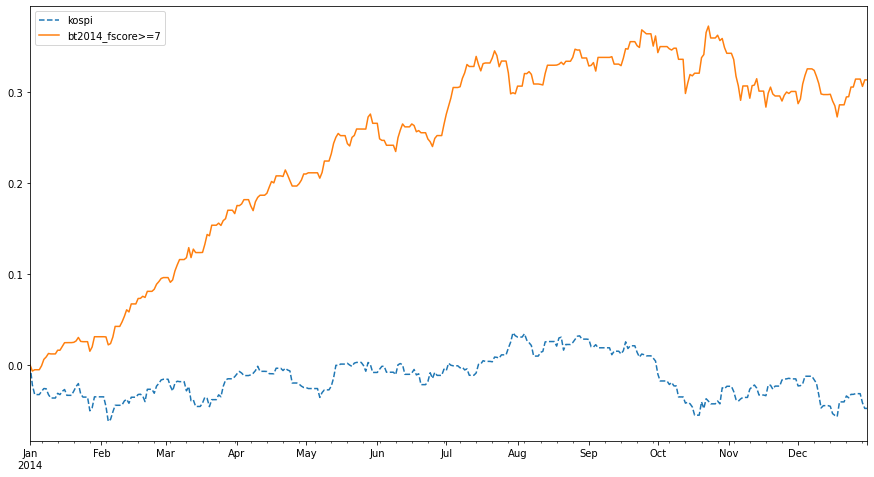

In [ ]:
visualize(std_df, 'kospi', [bt2014], ['bt2014_fscore>=7'])

In [ ]:
f2014[f2014['F.Score']>=7]

,종목명,종목코드,시장구분,산업분류,IPO_D,F.Score
1,삼성전자,A005930,코스피,전기전자,197506,7
2,SK하이닉스,A000660,코스피,전기전자,199612,8
20,한국전력,A015760,코스피,전기가스업,198908,8
37,코웨이,A021240,코스피,서비스업,200108,8
38,LG디스플레이,A034220,코스피,전기전자,200407,8
...,...,...,...,...,...,...
1414,경인전자,A009140,코스피,전기전자,198906,7
1415,삼화전자,A011230,코스피,전기전자,198705,7
1434,이스타코,A015020,코스피,서비스업,198812,9
1439,태원물산,A001420,코스피,운수장비,197506,7


In [ ]:
kcgs2013

,기업명,기업코드_보정,ESG등급N,환경N,사회N,지배구조N
NO,,,,,,
690,AK홀딩스,A006840,3,3,3,2
689,BNK금융지주,A138930,5,3,6,6
688,BYC,A001460,3,3,3,4
687,CJ,A001040,5,3,6,4
686,CJ CGV,A079160,3,3,3,4
...,...,...,...,...,...,...
6,휠라코리아,A081660,3,3,3,4
5,휴니드테크놀러지스,A005870,3,3,3,4
4,휴스틸,A005010,3,3,3,4


In [ ]:
kcgs2013[kcgs2013['ESG등급N']>4]

,기업명,기업코드_보정,ESG등급N,환경N,사회N,지배구조N
NO,,,,,,
689,BNK금융지주,A138930,5,3,6,6
687,CJ,A001040,5,3,6,4
685,CJ대한통운,A000120,5,5,6,5
683,CJ제일제당,A097950,5,6,6,4
679,DB손해보험,A005830,5,5,5,5
...,...,...,...,...,...,...
26,현대종합상사,A011760,5,3,5,5
25,현대중공업,A009540,6,6,6,5
22,현대해상,A001450,5,3,6,6


In [ ]:
f2014_7=f2014[f2014['F.Score']>=7]

In [ ]:
f2014_7

,종목명,종목코드,시장구분,산업분류,IPO_D,F.Score
1,삼성전자,A005930,코스피,전기전자,197506,7
2,SK하이닉스,A000660,코스피,전기전자,199612,8
20,한국전력,A015760,코스피,전기가스업,198908,8
37,코웨이,A021240,코스피,서비스업,200108,8
38,LG디스플레이,A034220,코스피,전기전자,200407,8
...,...,...,...,...,...,...
1414,경인전자,A009140,코스피,전기전자,198906,7
1415,삼화전자,A011230,코스피,전기전자,198705,7
1434,이스타코,A015020,코스피,서비스업,198812,9
1439,태원물산,A001420,코스피,운수장비,197506,7


In [ ]:
f2014_7[f2014_7['종목코드'].isin(kcgs2013[kcgs2013['ESG등급N']>2]['기업코드_보정'])]

,종목명,종목코드,시장구분,산업분류,IPO_D,F.Score
1,삼성전자,A005930,코스피,전기전자,197506,7
2,SK하이닉스,A000660,코스피,전기전자,199612,8
20,한국전력,A015760,코스피,전기가스업,198908,8
37,코웨이,A021240,코스피,서비스업,200108,8
38,LG디스플레이,A034220,코스피,전기전자,200407,8
...,...,...,...,...,...,...
1414,경인전자,A009140,코스피,전기전자,198906,7
1415,삼화전자,A011230,코스피,전기전자,198705,7
1434,이스타코,A015020,코스피,서비스업,198812,9
1439,태원물산,A001420,코스피,운수장비,197506,7


In [ ]:
v2014_7_3=quarry_value(f2014_7[f2014_7['종목코드'].isin(kcgs2013[kcgs2013['ESG등급N']>3]['기업코드_보정'])]['종목코드'], '2014-01-01', '2014-12-31', m_cursor)

fetching end.


In [ ]:
bt2014_7_3=backtest(v2014_7_3, seed_money=1000000000)

##### 그래프

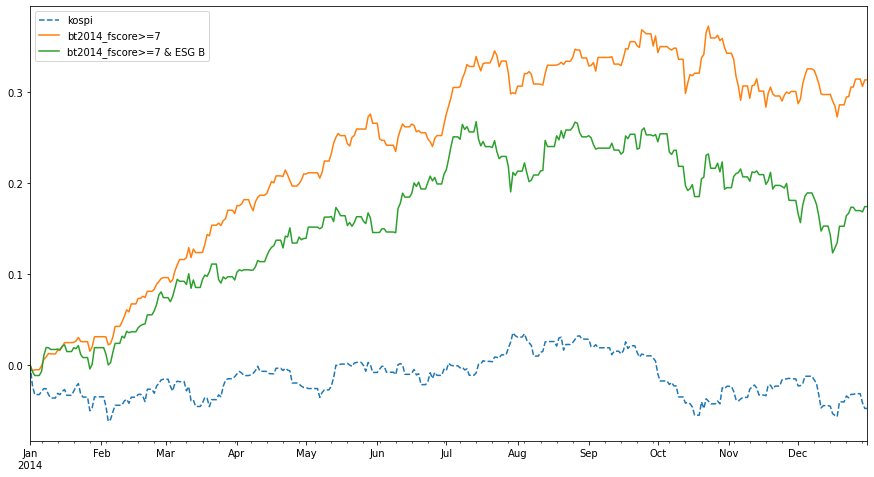

In [ ]:
visualize(std_df, 'kospi', [bt2014, bt2014_7_3], ['bt2014_fscore>=7', 'bt2014_fscore>=7 & ESG B'])

#### 2015

##### 코드

In [ ]:
####전처리

f2015=pd.read_excel("F_2015.xlsx", index_col=0)
str_list=[]
for num in f2015['종목코드']:
  str_list.append('A%06d'%num)
f2015['종목코드']=str_list

kcgs2014=ESG_DF_DICT['KCGS_ESG_2014'].copy()

#교집합
f2015=f2015[f2015['종목코드'].isin(kcgs2014['기업코드_보정'])]
kcgs2014=kcgs2014[kcgs2014['기업코드_보정'].isin(f2015['종목코드'])]

In [ ]:
v2015=quarry_value(f2015[f2015['F.Score']>=7]['종목코드'], '2015-01-01', '2015-12-31', m_cursor)

fetching end.


In [ ]:
bt2015=backtest(v2015, seed_money=1000000000)

In [ ]:
std_df=quarry_standard('2015-01-01', '2015-12-31', m_cursor)
std_df['total_change']=std_df['kospi']/std_df['kospi'][std_df.index[0]]-1

fetching end.


In [ ]:
f2015_7=f2015[f2015['F.Score']>=7]

In [ ]:
f2015_7[f2015_7['종목코드'].isin(kcgs2014[kcgs2014['ESG등급N']>2]['기업코드_보정'])]

,종목명,종목코드,시장구분,산업분류,IPO_D,F.Score
7,LG생활건강,A051900,코스피,화학,200104,7
12,엔씨소프트,A036570,코스피,서비스업,200305,7
22,한국전력,A015760,코스피,전기가스업,198908,8
25,아모레퍼시픽,A090430,코스피,화학,200606,7
39,CJ제일제당,A097950,코스피,음식료품,200709,8
...,...,...,...,...,...,...
1484,하이스틸,A071090,코스피,철강금속,200302,7
1488,한국전자홀딩스,A006200,코스피,금융업,197911,7
1492,진도,A088790,코스피,유통업,200603,7
1497,한솔PNS,A010420,코스피,유통업,198905,7


In [ ]:
v2015_7_3=quarry_value(f2015_7[f2015_7['종목코드'].isin(kcgs2014[kcgs2014['ESG등급N']>3]['기업코드_보정'])]['종목코드'], '2015-01-01', '2015-12-31', m_cursor)

fetching end.


In [ ]:
bt2015_7_3=backtest(v2015_7_3, seed_money=1000000000)

##### 그래프

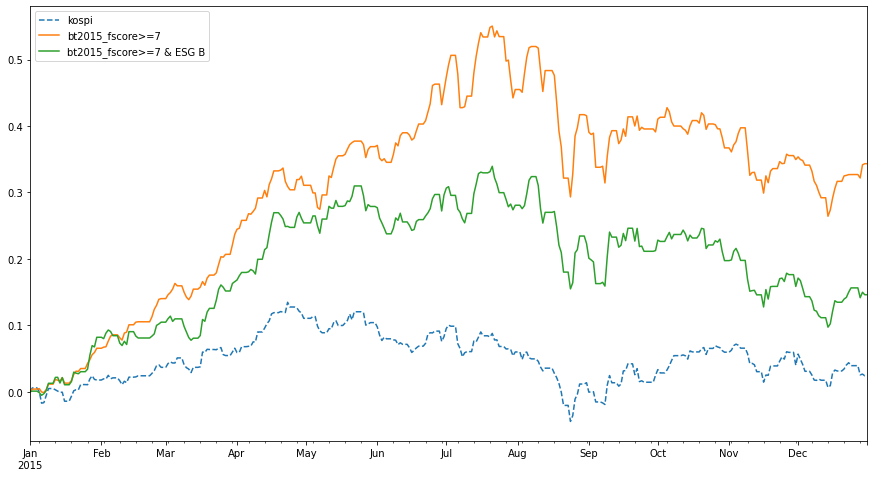

In [ ]:
visualize(std_df, 'kospi', [bt2015, bt2015_7_3], ['bt2015_fscore>=7', 'bt2015_fscore>=7 & ESG B'])

#### 2016


##### 코드

In [ ]:
std_df=quarry_standard('2016-01-01', '2016-12-31', m_cursor)
std_df['total_change']=std_df['kospi']/std_df['kospi'][std_df.index[0]]-1

fetching end.


In [ ]:
####전처리

f2016=pd.read_excel("F_2016.xlsx", index_col=0)
str_list=[]
for num in f2016['종목코드']:
  str_list.append('A%06d'%num)
f2016['종목코드']=str_list

kcgs2015=ESG_DF_DICT['KCGS_ESG_2015'].copy()

#교집합
f2016=f2016[f2016['종목코드'].isin(kcgs2015['기업코드_보정'])]
kcgs2015=kcgs2015[kcgs2015['기업코드_보정'].isin(f2016['종목코드'])]

In [ ]:
v2016=quarry_value(f2016[f2016['F.Score']>=7]['종목코드'], '2016-01-01', '2016-12-31', m_cursor)

fetching end.


In [ ]:
bt2016=backtest(v2016, seed_money=1000000000)

In [ ]:
f2016_7=f2016[f2016['F.Score']>=7]

In [ ]:
v2016_7_3=quarry_value(f2016_7[f2016_7['종목코드'].isin(kcgs2015[kcgs2015['ESG등급N']>3]['기업코드_보정'])]['종목코드'], '2016-01-01', '2016-12-31', m_cursor)

fetching end.


In [ ]:
bt2016_7_3=backtest(v2016_7_3, seed_money=1000000000)

##### 그래프

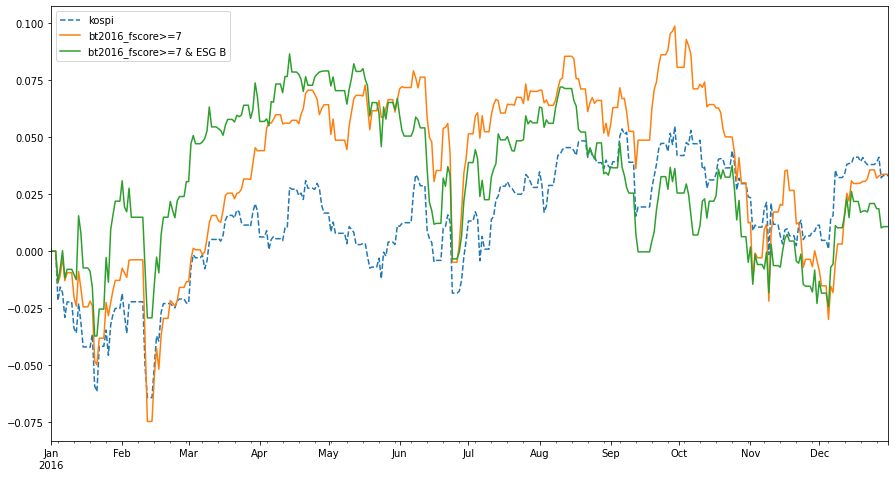

In [ ]:
visualize(std_df, 'kospi', [bt2016, bt2016_7_3], ['bt2016_fscore>=7', 'bt2016_fscore>=7 & ESG B'])

#### 2017 ~ 2019 (함수)

##### 함수

In [ ]:
def bt_fscore_filter(year, m_cursor):
  start_date='%d-01-01'%(year)
  end_date='%d-12-31'%(year)
  std_df=quarry_standard(start_date, end_date, m_cursor)
  std_df['total_change']=std_df['kospi']/std_df['kospi'][std_df.index[0]]-1

  ####전처리
  f2016=pd.read_excel("F_%d.xlsx"%(year), index_col=0)
  str_list=[]
  for num in f2016['종목코드']:
    str_list.append('A%06d'%num)
  f2016['종목코드']=str_list
  kcgs2015=ESG_DF_DICT['KCGS_ESG_%d'%(year-1)].copy()

  #교집합
  f2016=f2016[f2016['종목코드'].isin(kcgs2015['기업코드_보정'])]
  kcgs2015=kcgs2015[kcgs2015['기업코드_보정'].isin(f2016['종목코드'])]

  #F스코어 7보다 큰것 획득
  v2016=quarry_value(f2016[f2016['F.Score']>=7]['종목코드'], start_date, end_date, m_cursor)
  #백테스트
  bt2016=backtest(v2016, seed_money=1000000000)

  f2016_7=f2016[f2016['F.Score']>=7]
  #F스코어 7보다 크고 ESG B이상
  v2016_7_3=quarry_value(f2016_7[f2016_7['종목코드'].isin(kcgs2015[kcgs2015['ESG등급N']>3]['기업코드_보정'])]['종목코드'], start_date, end_date, m_cursor)
  bt2016_7_3=backtest(v2016_7_3, seed_money=1000000000)
  visualize(std_df, 'kospi', [bt2016, bt2016_7_3], ['bt%d_fscore>=7'%(year), 'bt%d_fscore>=7 & ESG B'%(year)])

##### 그래프

fetching end.
fetching end.
fetching end.


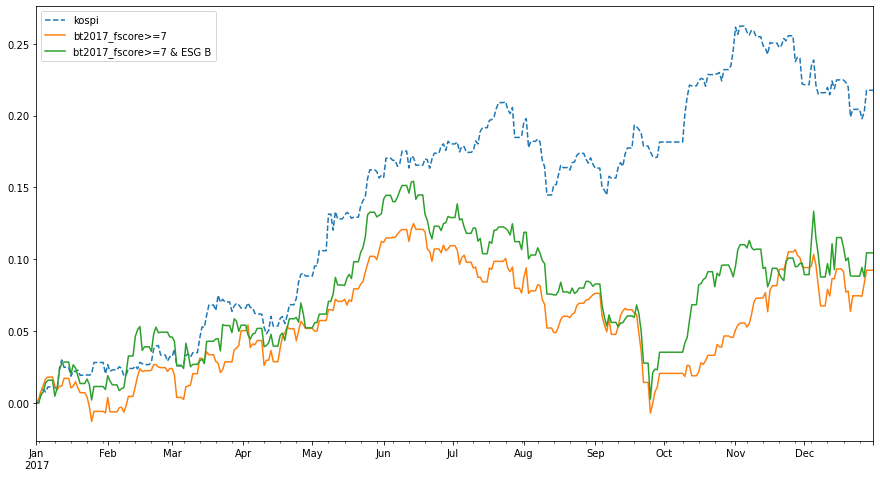

In [ ]:
bt_fscore_filter(2017, m_cursor)

fetching end.
fetching end.
fetching end.


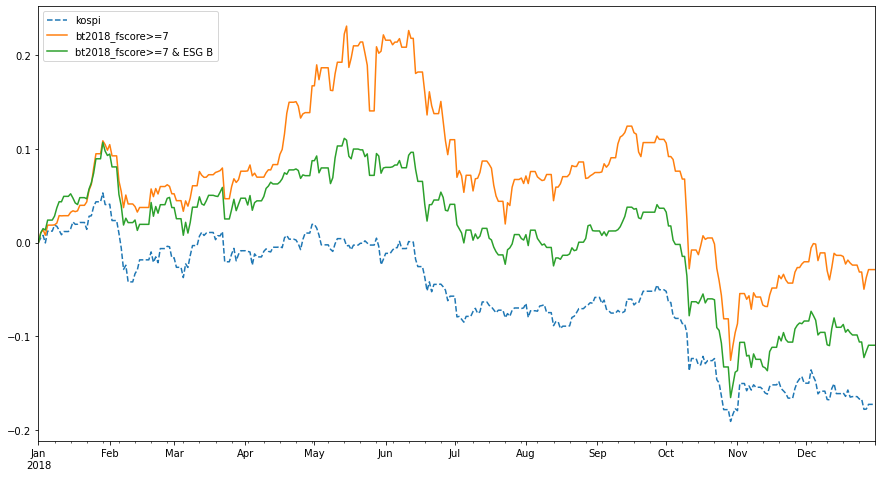

In [ ]:
bt_fscore_filter(2018, m_cursor)

fetching end.
fetching end.
fetching end.


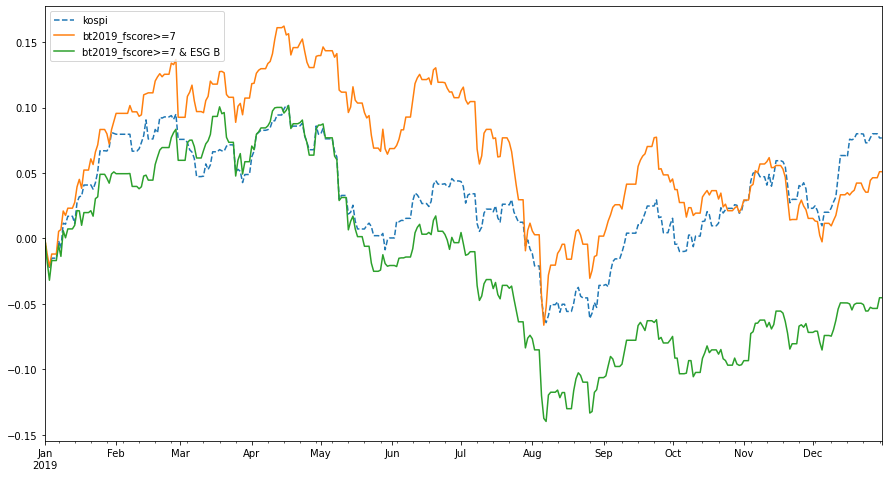

In [ ]:
bt_fscore_filter(2019, m_cursor)

##### 2020 코드

In [ ]:
def bt_fscore_filter_20(year, m_cursor):
  start_date='%d-01-01'%(year)
  end_date='%d-10-08'%(year)
  std_df=quarry_standard(start_date, end_date, m_cursor)
  std_df['total_change']=std_df['kospi']/std_df['kospi'][std_df.index[0]]-1

  ####전처리
  f2016=pd.read_excel("F_%d.xlsx"%(year), index_col=0)
  str_list=[]
  for num in f2016['종목코드']:
    str_list.append('A%06d'%num)
  f2016['종목코드']=str_list
  kcgs2015=ESG_DF_DICT['KCGS_ESG_%d'%(year-1)].copy()

  #교집합
  f2016=f2016[f2016['종목코드'].isin(kcgs2015['기업코드_보정'])]
  kcgs2015=kcgs2015[kcgs2015['기업코드_보정'].isin(f2016['종목코드'])]

  #F스코어 7보다 큰것 획득
  v2016=quarry_value(f2016[f2016['F.Score']>=7]['종목코드'], start_date, end_date, m_cursor)
  #백테스트
  bt2016=backtest(v2016, seed_money=1000000000)

  f2016_7=f2016[f2016['F.Score']>=7]
  #F스코어 7보다 크고 ESG B이상
  v2016_7_3=quarry_value(f2016_7[f2016_7['종목코드'].isin(kcgs2015[kcgs2015['ESG등급N']>3]['기업코드_보정'])]['종목코드'], start_date, end_date, m_cursor)
  bt2016_7_3=backtest(v2016_7_3, seed_money=1000000000)
  visualize(std_df, 'kospi', [bt2016, bt2016_7_3], ['bt%d_fscore>=7'%(year), 'bt%d_fscore>=7 & ESG B'%(year)])

##### 2020 그래프

fetching end.
fetching end.
fetching end.


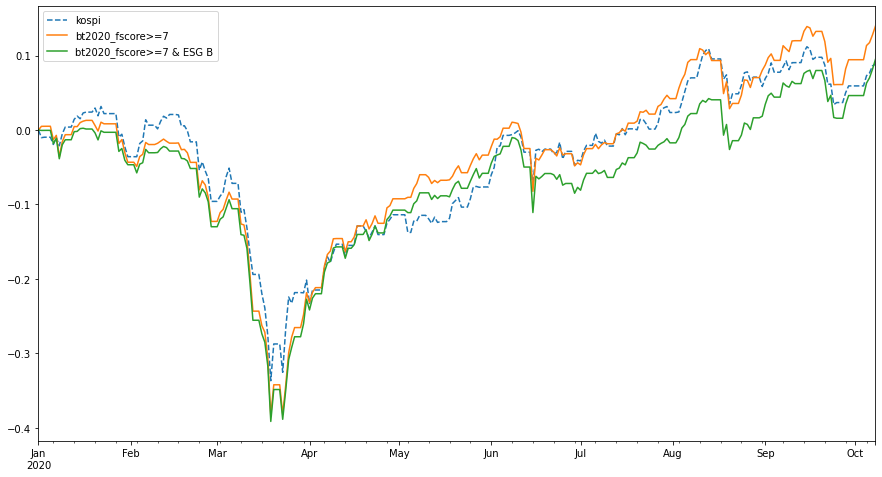

In [ ]:
bt_fscore_filter_20(2020, m_cursor)